In [18]:
# Install required packages.
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

# Helper function for visualization.
%matplotlib inline
import networkx as nx
import matplotlib.pyplot as plt


1.11.0+cu113


In [19]:
pip install deepchem

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [64]:
import torch
import pandas as pd
import numpy as np
import torch_geometric.transforms as T
import torch_geometric
from torch_geometric.data import Dataset
import numpy as np 
import os
import deepchem as dc
import torch.nn as nn
from torch.nn import Linear,BatchNorm1d
from torch_geometric.nn import GCNConv,GATConv
from torch_geometric.nn import BatchNorm
from tqdm import tqdm
from torch_geometric.data import DataLoader
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from matplotlib import pyplot
from sklearn import metrics
from sklearn.preprocessing import label_binarize
from sklearn.metrics import average_precision_score
import seaborn as sns
import pandas as pd 
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import math
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings("ignore")

In [21]:
data = pd.read_csv('raw/totalData.csv')
data.head() 

,Unnamed: 0,Drug1_ID,Drug1_SMILES
0,0,DB00706,CCOc1ccccc1OCCN[C@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1
1,1,DB01023,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc(Cl)c1Cl
2,2,3849.0,C[C@@H](Oc1ccc2[nH]nc(/C=C/c3cnn(CCO)c3)c2c1)c...
3,3,3515.0,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(I)cc1
4,4,6380.0,O=P(O)(O)OCCCc1c[nH]c2ccccc12


In [66]:


remove = []

class MoleculeDataset(Dataset):
    def __init__(self, root, filename, test=False, transform=None, pre_transform=None):
        """
        root = Where the dataset should be stored. This folder is split
        into raw_dir (downloaded dataset) and processed_dir (processed data). 
        """
        self.test = test
        self.filename = filename
        self.sz = 0
        super(MoleculeDataset, self).__init__(root, transform, pre_transform)
        
    @property
    def raw_file_names(self):
        """ If this file exists in raw_dir, the download is not triggered.
            (The download func. is not implemented here)  
        """
        return self.filename

    @property
    def processed_file_names(self):
        """ If these files are found in raw_dir, processing is skipped"""
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()

        if self.test:
            return [f'data_test_{i}.pt' for i in list(self.data.index)]
        else:
            return [f'data_{i}.pt' for i in list(self.data.index)]
        

    def download(self):
        pass

    def process(self):
        self.data = pd.read_csv(self.raw_paths[0]).reset_index()
        featurizer = dc.feat.MolGraphConvFeaturizer(use_edges=True)
        count = 0
        for index, mol in tqdm(self.data.iterrows(), total=self.data.shape[0]):
            if type(mol["Drug1_SMILES"])==float:
              remove.append(mol["Drug1_ID"])
              continue
            f = featurizer.featurize(mol["Drug1_SMILES"])
            if not f : 
              remove.append(mol["Drug1_ID"])
              continue
            data = f[0].to_pyg_graph()
            data.y = 1
            data.smiles = mol["Drug1_SMILES"]
            data.id = mol["Drug1_ID"]
            if self.test:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                f'data_test_{count}.pt'))
            else:
                torch.save(data, 
                    os.path.join(self.processed_dir, 
                                f'data_{count}.pt'))
            count+=1
        self.sz = count

    def _get_label(self, label):
        label = np.asarray([label])
        return torch.tensor(label, dtype=torch.int64)

    def len(self):
        return self.sz
        #return self.data.shape[0]

    def get(self, idx):
        """ - Equivalent to __getitem__ in pytorch
            - Is not needed for PyG's InMemoryDataset
        """
        if self.test:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_test_{idx}.pt'))
        else:
            data = torch.load(os.path.join(self.processed_dir, 
                                 f'data_{idx}.pt'))        
        return data

encoder_set = MoleculeDataset("","totalData.csv")

In [29]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [30]:
len(encoder_set)

10820

In [31]:
class GVAE(nn.Module):
    def __init__(self, feature_size, edge_size):
        super(GVAE, self).__init__()
        self.encoder_embedding_size = 48
        self.feature_size = feature_size
        self.edge_dim = edge_size
        self.latent_embedding_size = 8
        self.decoder_hidden_neurons = 64
        decoder_size = 64

        # Encoder layers
        self.conv1 = GATConv(feature_size, self.encoder_embedding_size,edge_dim=self.edge_dim)
        #self.conv1 = GCNConv(feature_size, self.encoder_embedding_size)
        self.bn1 = BatchNorm(self.encoder_embedding_size)
        self.conv2 = GCNConv(self.encoder_embedding_size, self.encoder_embedding_size)
        self.bn2 = BatchNorm(self.encoder_embedding_size)
        self.conv3 = GCNConv(self.encoder_embedding_size, self.encoder_embedding_size)
        self.bn3 = BatchNorm(self.encoder_embedding_size)

        # Latent transform layers
        self.mu_transform = Linear(self.encoder_embedding_size, 
                                            self.latent_embedding_size)
        self.logvar_transform = Linear(self.encoder_embedding_size, 
                                            self.latent_embedding_size)
 
        
      
        self.decoder_dense_3 = Linear(self.latent_embedding_size, decoder_size)
        self.decoder_bn_3 = BatchNorm1d(decoder_size)
        self.decoder_dense_4 = Linear(decoder_size, self.feature_size)
        

    def encode(self, x, edge_attr, edge_index, batch_index):
        # GNN layers
        #x = self.conv1(x, edge_index).relu()
        x = self.conv1(x, edge_index, edge_attr).relu()
        x = self.bn1(x)
        x = self.conv2(x, edge_index).relu()
        x = self.bn2(x)
        x = self.conv3(x, edge_index).relu()
        x = self.bn3(x)
        
        # Latent transform layers
        mu = self.mu_transform(x)
        logvar = self.logvar_transform(x)
        return mu, logvar


    def decode(self, z, batch_index):
        x = self.decoder_dense_3(z).relu()
        x = self.decoder_bn_3(x)
        x = self.decoder_dense_4(x)
        return x


    def reparameterize(self, mu, logvar):
        if self.training:
            std = torch.exp(logvar)
            eps = torch.randn_like(std)
            return eps.mul(std).add_(mu)
        else:
            return mu

    def forward(self, x, edge_attr, edge_index, batch_index):
        mu, logvar = self.encode(x, edge_attr, edge_index, batch_index)
        z = self.reparameterize(mu, logvar)
        triu_logits = self.decode(z, batch_index)

        return triu_logits, mu, logvar

    
   
model = GVAE(feature_size=encoder_set[0].x.shape[1],edge_size=encoder_set[0].edge_attr.shape[1])
print(model)
print("Number of parameters: ", sum(p.numel() for p in model.parameters()))

GVAE(
  (conv1): GATConv(30, 48, heads=1)
  (bn1): BatchNorm(48)
  (conv2): GCNConv(48, 48)
  (bn2): BatchNorm(48)
  (conv3): GCNConv(48, 48)
  (bn3): BatchNorm(48)
  (mu_transform): Linear(in_features=48, out_features=8, bias=True)
  (logvar_transform): Linear(in_features=48, out_features=8, bias=True)
  (decoder_dense_3): Linear(in_features=8, out_features=64, bias=True)
  (decoder_bn_3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (decoder_dense_4): Linear(in_features=64, out_features=30, bias=True)
)
Number of parameters:  10590


In [32]:
data_size = len(encoder_set)
NUM_GRAPHS_PER_BATCH = 64
frac = 0.75
train_loader = DataLoader(encoder_set[:int(data_size * frac)], 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)
test_loader = DataLoader(encoder_set[int(data_size * frac):], 
                         batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)


model = model.to(device)


In [33]:
def kl_loss(mu=None, logstd=None):
    """
    Closed formula of the KL divergence for normal distributions
    """
    MAX_LOGSTD = 10
    logstd =  logstd.clamp(max=MAX_LOGSTD)
    kl_div = -0.5 * torch.mean(torch.sum(1 + 2 * logstd - mu**2 - logstd.exp()**2, dim=1))

    # Limit numeric errors
    kl_div = kl_div.clamp(max=1000)
    return kl_div



In [34]:
def gvae_loss(decode_pred, edge_index, node_feats, mu, logvar, batch_index, kl_beta):
    # Convert target edge index to dense adjacency matrix
    batch_targets = torch.squeeze(to_dense_adj(edge_index))
    batch_targets = batch_targets + torch.eye(batch_targets.shape[0]).to(device)
    degree = torch.diag(torch.sum(batch_targets, axis=1))
    dinv = torch.linalg.inv(degree)
    dinvsqrt = torch.sqrt(dinv)
    mat = torch.matmul(dinvsqrt,batch_targets)
    mat = torch.matmul(mat,dinvsqrt)
    mat = torch.matmul(mat,node_feats)
    
    # Reconstruction loss per graph
    res = mat - decode_pred
    
    ssq = (torch.diag(torch.mm(res,res.T)))
    batch_recon_loss = torch.sum(ssq)/(ssq.shape[0])
    
    
    # KL Divergence
    kl_divergence = kl_loss(mu, logvar)

    return batch_recon_loss + kl_beta * kl_divergence, kl_divergence

In [35]:
loss_fn = gvae_loss
optimizer = torch.optim.Adam(model.parameters(), lr=0.002)
kl_beta = 0.005

In [36]:

def run_one_epoch(data_loader, type, epoch, kl_beta):
    # Store per batch loss and accuracy 
    all_losses = []
    all_accs = []
    all_kldivs = []

    # Iterate over data loader
    for i, batch in enumerate(tqdm(data_loader)):
        # Some of the data points have invalid adjacency matrices 
        try:
            # Use GPU
            batch.to(device)  
            # Reset gradients
            optimizer.zero_grad() 
            # Call model
            decode_pred, mu, logvar = model(batch.x.float(), 
                                            batch.edge_attr.float(),
                                            batch.edge_index, 
                                            batch.batch) 
            # Calculate loss and backpropagate
            
            
            loss, kl_div = loss_fn(decode_pred, batch.edge_index, batch.x.float(), mu, logvar, batch.batch, kl_beta)
            if type == "Train":
                loss.backward()  
                optimizer.step()  
            # Calculate metrics
            # Store loss and metrics
            all_losses.append(loss.detach().cpu().numpy())
            all_kldivs.append(kl_div.detach().cpu().numpy())
            

        except IndexError as error:
            print("Error: ", error)
    
    print(f"{type} epoch {epoch} loss: ", np.array(all_losses).mean())
    print(f"{type} epoch {epoch} KL-loss: ", np.array(all_kldivs).mean())
    

In [37]:
for epoch in range(11): 
  model.train()
  run_one_epoch(train_loader, type="Train", epoch=epoch, kl_beta=kl_beta)
  if epoch % 5 == 0:
      print("Start test epoch...")
      model.eval()
      run_one_epoch(test_loader, type="Test", epoch=epoch, kl_beta=kl_beta)

100%|██████████| 127/127 [00:08<00:00, 14.92it/s]


Train epoch 0 loss:  6.9501114
Train epoch 0 KL-loss:  846.89764
Start test epoch...


100%|██████████| 43/43 [00:02<00:00, 16.87it/s]


Test epoch 0 loss:  5.256702
Test epoch 0 KL-loss:  764.58575


100%|██████████| 127/127 [00:07<00:00, 16.06it/s]


Train epoch 1 loss:  2.5992348
Train epoch 1 KL-loss:  363.68423


100%|██████████| 127/127 [00:08<00:00, 15.68it/s]


Train epoch 2 loss:  0.55579513
Train epoch 2 KL-loss:  17.16624


100%|██████████| 127/127 [00:07<00:00, 16.01it/s]


Train epoch 3 loss:  0.45089385
Train epoch 3 KL-loss:  15.207352


100%|██████████| 127/127 [00:07<00:00, 16.11it/s]


Train epoch 4 loss:  0.39065725
Train epoch 4 KL-loss:  14.328433


100%|██████████| 127/127 [00:07<00:00, 16.13it/s]


Train epoch 5 loss:  0.34828806
Train epoch 5 KL-loss:  13.764778
Start test epoch...


100%|██████████| 43/43 [00:02<00:00, 17.40it/s]


Test epoch 5 loss:  0.28201818
Test epoch 5 KL-loss:  13.855026


100%|██████████| 127/127 [00:07<00:00, 15.92it/s]


Train epoch 6 loss:  0.32218957
Train epoch 6 KL-loss:  13.455456


100%|██████████| 127/127 [00:09<00:00, 13.99it/s]


Train epoch 7 loss:  0.30057326
Train epoch 7 KL-loss:  13.204031


100%|██████████| 127/127 [00:07<00:00, 16.00it/s]


Train epoch 8 loss:  0.28554648
Train epoch 8 KL-loss:  13.067445


100%|██████████| 127/127 [00:08<00:00, 15.73it/s]


Train epoch 9 loss:  0.27616805
Train epoch 9 KL-loss:  12.956231


100%|██████████| 127/127 [00:07<00:00, 16.01it/s]


Train epoch 10 loss:  0.26413715
Train epoch 10 KL-loss:  12.85483
Start test epoch...


100%|██████████| 43/43 [00:02<00:00, 17.10it/s]

Test epoch 10 loss:  0.22354986
Test epoch 10 KL-loss:  12.943735


In [38]:
NUM_GRAPHS_PER_BATCH = 1
loader = DataLoader(encoder_set, 
                    batch_size=NUM_GRAPHS_PER_BATCH, shuffle=False)

dictval = {}
for batch in loader : 
  batch.to(device)
  decode_pred, mu, logvar = model(batch.x.float(), 
                            batch.edge_attr.float(),
                            batch.edge_index, 
                            batch.batch) 
  
  
  dictval[batch.id[0]] = [mu,logvar]
  
print("done!!!")
  

      

done!!!


In [39]:
temp = pd.read_csv("sup_train_val.csv")
temp.head()

,Unnamed: 0,Drug1_ID,Drug1_SMILES,Drug2_ID,Drug2_SMILES,label
0,0,DB00706,CCOc1ccccc1OCCN[C@H](C)Cc1ccc(OC)c(S(N)(=O)=O)c1,DB01023,CCOC(=O)C1=C(C)NC(C)=C(C(=O)OC)C1c1cccc(Cl)c1Cl,1.0
1,1,3849.0,C[C@@H](Oc1ccc2[nH]nc(/C=C/c3cnn(CCO)c3)c2c1)c...,3515.0,COc1ccc2c(c1)c(CC(=O)O)c(C)n2C(=O)c1ccc(I)cc1,0.0
2,2,6380.0,O=P(O)(O)OCCCc1c[nH]c2ccccc12,8290.0,N[C@@H](c1ccccc1)c1ccc(-c2ncnc3[nH]cnc23)cc1,0.0
3,3,7947.0,CCCC(=O)O[C@]1(C(=O)COC(C)=O)CC[C@H]2[C@@H]3C[...,3010.0,CNCCc1ccccn1,0.0
4,4,DB00802,CCC(=O)N(c1ccccc1)C1(COC)CCN(CCn2nnn(CC)c2=O)CC1,DB00872,Cc1nc2c([nH]1)CCN(C(=O)c1ccc(NC(=O)c3ccccc3-c3...,1.0


In [40]:
df = temp

# df = pd.DataFrame(columns = ['Drug1_ID', 'Drug1_SMILES', 'Drug2_ID','Drug2_SMILES','label'])

# sz = len(temp)

# for i in range(sz):
#   id1 = temp['Drug1_ID'][i]
#   id2 = temp['Drug2_ID'][i]
#   if (id1 in dictval) and (id2 in dictval) : 
#     df = df.append({'Drug1_ID' : id1, 'Drug1_SMILES' : temp['Drug1_SMILES'][i], 'Drug2_ID' : id2,'Drug2_SMILES' : temp['Drug2_SMILES'][i],'label' : temp['label'][i]}, 
#                   ignore_index = True)

# df.head()

In [41]:
n_classes = len(df['label'].unique())
n_classes

2

In [42]:
df['label'].value_counts()

1.0    33243
0.0    33189
Name: label, dtype: int64

In [43]:
dftrain = df
dftest = pd.read_csv("sup_test.csv")

In [44]:

class NumbersDataset(Dataset):
    def __init__(self,filename):
        datat = dftrain
        
        self.samples = list(range(2*len(datat)))
        self.label = list(range(2*len(datat)))
        self.sz = 0
        idx = 0
        for index in range(len(datat)) :
          str1 = datat['Drug1_ID'][index]
          str2 = datat['Drug2_ID'][index]

          if (str1 in dictval) and (str2 in dictval) :
            loop = 0
            if datat['label'][index]==0 :
              loop = 0
            elif datat['label'][index]==1 :
              loop = 0
            else :
              loop = 0

            mat1 = dictval[str1][0]
            mat2 = dictval[str2][0]
            mean1 = torch.mean(mat1, axis = 0)
            std1 = torch.std(mat1, axis = 0)
            mean2 = torch.mean(mat2, axis = 0)
            std2 = torch.std(mat2, axis = 0)
            vect = torch.cat([mean1, mean2, std1, std2], dim=0)
            self.samples[idx] = vect.detach().cpu()
            self.label[idx] = datat['label'][index]
            self.label[idx] = torch.tensor(self.label[idx], dtype=torch.int64)
            idx+=1
            for genvar in range(0,loop) : 
              eps = torch.randn_like(dictval[str1][1])
              std = torch.exp(dictval[str1][1])
              mat1 = eps.mul(std).add_(dictval[str1][0])
              eps = torch.randn_like(dictval[str2][1])
              std = torch.exp(dictval[str2][1])
              mat2 = eps.mul(std).add_(dictval[str2][0])
              mean1 = torch.mean(mat1, axis = 0)
              std1 = torch.std(mat1, axis = 0)
              mean2 = torch.mean(mat2, axis = 0)
              std2 = torch.std(mat2, axis = 0)
              vect = torch.cat([mean1, mean2, std1, std2], dim=0)
              self.samples[idx] = vect.detach().cpu()
              self.label[idx] = datat['label'][index]
              self.label[idx] = torch.tensor(self.label[idx], dtype=torch.int64)
              idx+=1
        self.sz = idx


    def __len__(self):
        return self.sz

    def __getitem__(self, idx):
        return self.samples[idx],self.label[idx]

dataset = NumbersDataset("sup_train_val.csv")
len(dataset)

65075

In [45]:
data = dataset

In [46]:
data[0][1]

tensor(1)

In [47]:
import torch.nn.functional as F 


class NeuralNet(torch.nn.Module):
    def __init__(self, input_size, hidden_size):
        super(NeuralNet, self).__init__()
        self.input_size = input_size
        self.hidden_size  = hidden_size
        self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
        self.relu = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(self.hidden_size, n_classes)
        
    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = F.softmax(x, dim=1)
        return x
model_ff = NeuralNet(data[0][0].shape[0],128)
print(model_ff)
print("Number of parameters: ", sum(p.numel() for p in model_ff.parameters()))

NeuralNet(
  (fc1): Linear(in_features=32, out_features=128, bias=True)
  (relu): ReLU()
  (fc2): Linear(in_features=128, out_features=2, bias=True)
)
Number of parameters:  4482


In [48]:
# import torch.nn.functional as F 


# class NeuralNet(torch.nn.Module):
#     def __init__(self, input_size, hidden_size):
#         super(NeuralNet, self).__init__()
#         self.input_size = input_size
#         self.hidden_size  = hidden_size
#         self.fc1 = torch.nn.Linear(self.input_size, self.hidden_size)
#         self.relu = torch.nn.ReLU()
#         self.fc2 = torch.nn.Linear(self.hidden_size, self.hidden_size)
#         self.fc3 = torch.nn.Linear(self.hidden_size, n_classes)
        
#     def forward(self, x):
#         x = self.fc1(x)
#         x = self.relu(x)
#         x = self.fc2(x)
#         x = self.relu(x)
#         x = self.fc3(x)
#         x = F.softmax(x, dim=1)
#         return x
# model_ff = NeuralNet(data[0][0].shape[0],64)
# print(model_ff)
# #print("Number of parameters: ", sum(p.numel() for p in model_ff.parameters()))

In [49]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_ff.parameters(), lr=0.001)  
model_ff = model_ff.to(device)
loss_fn = loss_fn.to(device)

# Wrap data in a data loader
data_size = len(data)
NUM_GRAPHS_PER_BATCH = 128
loader = DataLoader(data,batch_size=NUM_GRAPHS_PER_BATCH, shuffle=True)



def train(data):
    for batch in loader:
      # Use GPU
      
      batch[0] = batch[0].to(device) 
      batch[1] = batch[1].to(device)  
      # Reset gradients
      optimizer.zero_grad() 
      # Passing the node features and the connection info
      pred = model_ff(batch[0]) 
      
      loss = (loss_fn(pred, batch[1]))      
      loss.backward()  
      # Update using the gradients
      optimizer.step()   
    return loss

print("Starting training...")
losses = []
for epoch in range(301):
    loss = train(data)
    losses.append(loss)
    if epoch % 50 == 0:
      print(f"Epoch {epoch} | Train Loss {loss}")

Starting training...
Epoch 0 | Train Loss 0.5785036087036133
Epoch 50 | Train Loss 0.44032445549964905
Epoch 100 | Train Loss 0.38921141624450684
Epoch 150 | Train Loss 0.3734346926212311
Epoch 200 | Train Loss 0.36412668228149414
Epoch 250 | Train Loss 0.36788520216941833
Epoch 300 | Train Loss 0.399596631526947


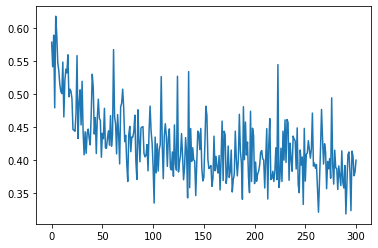

In [50]:
# Visualize learning (training loss)
losses_float = [float(loss.cpu().detach().numpy()) for loss in losses] 
loss_indices = [i for i,l in enumerate(losses_float)] 
plt = sns.lineplot(loss_indices, losses_float)
plt

In [51]:

class TestDataset(Dataset):
    def __init__(self,filename):
        datat = dftest
        #datat = datat.tail(tailpp).reset_index(drop=True)
       
        self.samples = list(range(len(datat)))
        self.label = list(range(len(datat)))
        self.sz = 0
        idx = 0
        for index in range(len(datat)) :
          str1 = datat['Drug1_ID'][index]
          str2 = datat['Drug2_ID'][index]

          
          if (str1 in dictval) and (str2 in dictval) :
            mat1 = dictval[str1][0]
            mat2 = dictval[str2][0]
            mean1 = torch.mean(mat1, axis = 0)
            std1 = torch.std(mat1, axis = 0)
            mean2 = torch.mean(mat2, axis = 0)
            std2 = torch.std(mat2, axis = 0)
            vect = torch.cat([mean1, mean2, std1, std2], dim=0)
            self.samples[idx] = vect.detach().cpu()
            self.label[idx] = datat['label'][index]
            self.label[idx] = torch.tensor(self.label[idx], dtype=torch.int64)
            idx+=1
        self.sz = idx


    def __len__(self):
        return self.sz

    def __getitem__(self, idx):
        return self.samples[idx],self.label[idx]

datatest = TestDataset("sup_test.csv")
len(datatest)

16234

In [52]:
test_loader = DataLoader(datatest,batch_size=len(datatest), shuffle=True)
dffull = pd.DataFrame(columns = ['y_real','y_pred'])
with torch.no_grad():
    for test_batch in test_loader : 
      test_batch[0] = test_batch[0].to(device)
      test_batch[1] = test_batch[1].to(device)
      pred = model_ff(test_batch[0]) 
      pred_frac0 = pred[:,0]
      pred_frac1 = pred[:,1]
      if n_classes == 3 : 
        pred_frac2 = pred[:,2]
      pred = pred.argmax(dim=1)  
      dftt = pd.DataFrame()
      dftt["y_real"] = test_batch[1].tolist()
      dftt["y_pred"] = pred.tolist()
      dftt["y_predfrac0"] = pred_frac0.tolist()
      dftt["y_predfrac1"] = pred_frac1.tolist()
      if n_classes == 3 : 
        dftt["y_predfrac2"] = pred_frac2.tolist()
      dffull = dffull.append(dftt)
      print(f1_score(dftt['y_real'], dftt['y_pred'],average='macro'))

dffull.to_csv('tt.csv')
dffull.tail()

0.8857755823808908


,y_real,y_pred,y_predfrac0,y_predfrac1
16229,1,1,1.366280e-03,0.998634
16230,0,0,9.999909e-01,0.000009
16231,1,1,4.056687e-05,0.999959
16232,1,1,2.187318e-04,0.999781
16233,1,1,8.393649e-08,1.000000


In [53]:
datahead = pd.read_csv('tt.csv')
print(f1_score(datahead['y_real'], datahead['y_pred'],average='macro'))
print(f1_score(datahead['y_real'], datahead['y_pred'],average='micro'))
print(accuracy_score(datahead['y_real'], datahead['y_pred']))

confusion_matrix(datahead['y_real'], datahead['y_pred'])

0.8857755823808908
0.8858568436614512
0.8858568436614512


array([[6974, 1135],
       [ 718, 7407]])

In [54]:
dfttt = datahead.iloc[:,3:]
dfttt.head()

,y_predfrac0,y_predfrac1
0,1.000000e+00,1.274436e-31
1,9.999951e-01,4.886387e-06
2,1.376538e-09,1.000000e+00
3,1.000000e+00,2.981653e-11
4,1.000000e+00,3.357204e-09


In [55]:
probab = dfttt.to_numpy()

In [56]:
if n_classes==3 : 
  macro_roc_auc_ovo = roc_auc_score(datahead['y_real'],probab, multi_class="ovo", average="macro")
  print(macro_roc_auc_ovo)
  macro_roc_auc_ovo = roc_auc_score(datahead['y_real'],probab, multi_class="ovr", average="weighted")
  print(macro_roc_auc_ovo)

In [57]:
if n_classes == 3 : 
  Y_test = datahead['y_real']
  y_score = probab
  # Use label_binarize to be multi-label like settings
  Y = label_binarize(Y_test, classes=[0, 1, 2])
  n_classes = Y.shape[1]

  Y_test = Y


  # For each class
  precision = dict()
  recall = dict()
  average_precision = dict()
  for i in range(n_classes):
      precision[i], recall[i], _ = precision_recall_curve(Y_test[:, i], y_score[:, i])
      average_precision[i] = average_precision_score(Y_test[:, i], y_score[:, i])

  # A "micro-average": quantifying score on all classes jointly
  precision["micro"], recall["micro"], _ = precision_recall_curve(
      Y_test.ravel(), y_score.ravel()
  )
  average_precision["micro"] = average_precision_score(Y_test, y_score, average="micro")
  average_precision["macro"] = average_precision_score(Y_test, y_score, average="macro")
  print(average_precision["micro"])
  print(average_precision["macro"])

In [58]:
from sklearn.metrics import PrecisionRecallDisplay
if n_classes == 3 :
  display = PrecisionRecallDisplay(
      recall=recall["micro"],
      precision=precision["micro"],
      average_precision=average_precision["micro"],
  )
  display.plot()
  _ = display.ax_.set_title("Micro-averaged over all classes")

In [59]:
#NEXT CELLS FOR NUMBER OF CLASSES = 2

In [60]:
auc = roc_auc_score(datahead['y_real'],datahead['y_predfrac1'])
print('AUC: %.3f' % auc)

AUC: 0.932


Model: ROC AUC=0.932


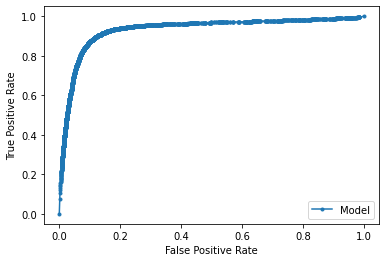

In [61]:
lr_auc = roc_auc_score(datahead['y_real'],datahead['y_predfrac1'])
# summarize scores

print('Model: ROC AUC=%.3f' % (lr_auc))
# calculate roc curves

lr_fpr, lr_tpr, _ = roc_curve(datahead['y_real'],datahead['y_predfrac1'])
# plot the roc curve for the model
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='Model')
# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

Logistic: f1=0.889 auc=0.930


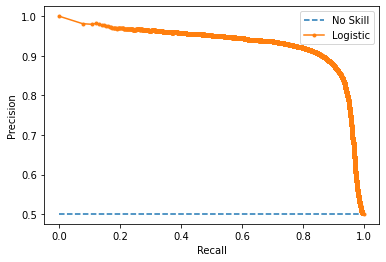

In [62]:
lr_precision, lr_recall, _ = precision_recall_curve(datahead['y_real'],datahead['y_predfrac1'])
lr_f1, lr_auc = f1_score(datahead['y_real'], datahead['y_pred']), metrics.auc(lr_recall, lr_precision)
# summarize scores
print('Logistic: f1=%.3f auc=%.3f' % (lr_f1, lr_auc))
# plot the precision-recall curves
no_skill = len(datahead['y_real'][datahead['y_real']==1]) / len(datahead['y_real'])
pyplot.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
pyplot.plot(lr_recall, lr_precision, marker='.', label='Logistic')
# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [63]:
precision, recall, thresholds  = precision_recall_curve(datahead['y_real'], datahead['y_predfrac1'])
auc_score = metrics.auc(recall, precision)
auc_score

0.9297242736187928